In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp

import quflow as qf
from cupyx.profiler import benchmark

Shown below is the execution time for different matrix size $N$ for both GPU and CPU, aswell as the respective speedup. The variables `time = 3.0`, `inner_time = 0.5` and
`qstepsize = 0.2` are fixed.

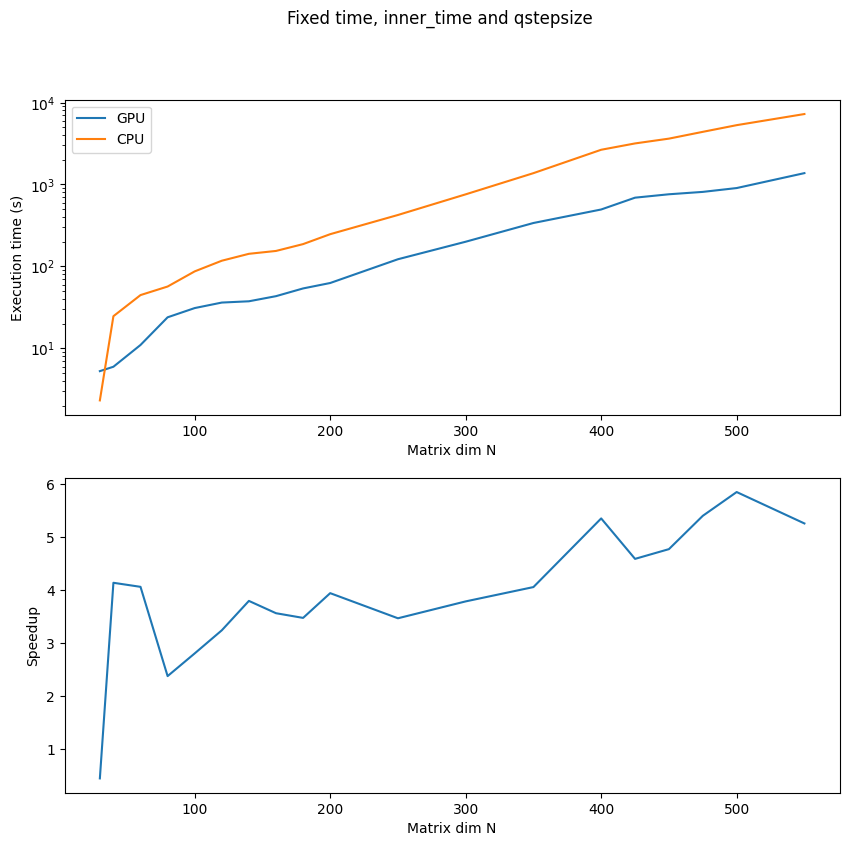

In [2]:
with open("speed_test2.json","r") as f:
    speed_data = json.load(f)



timings = np.array(speed_data["timings"])
n_samples = np.array(speed_data["n_samples"])

speedup = timings[1,:]/timings[0,:]

fig, ax = plt.subplots(2,1,figsize = (10,9))

fig.suptitle('Fixed time, inner_time and qstepsize')
# Execution time plot
ax[0].plot(n_samples,timings.T,label=["GPU","CPU"])

ax[0].set_yscale("log")
#ax[0].set_xscale("log")

ax[0].set_ylabel("Execution time (s)")
ax[0].set_xlabel("Matrix dim N")
ax[0].legend()

# Speedup plot

ax[1].plot(n_samples,speedup)

#ax[1].set_yscale("log")
#ax[1].set_xscale("log")

ax[1].set_ylabel("Speedup")
ax[1].set_xlabel("Matrix dim N")
#ax[1].legend()

plt.savefig("gpu_cpu_timings")

In [2]:
def get_random_mat_cp(N=5,seed=None):
    if seed != None:
        cp.random.seed(seed)

    W = cp.random.randn(N, N) + 1j*cp.random.randn(N, N)
    W -= W.conj().T
    W -= cp.eye(N)*cp.trace(W)/N
    return W

def get_random_mat_np(N=5,seed=None):
    if seed != None:
        np.random.seed(seed)

    W = np.random.randn(N, N) + 1j*np.random.randn(N, N)
    W -= W.conj().T
    W -= np.eye(N)*np.trace(W)/N
    return W

def mult(A,B,C):
    cp.matmul(A,B,out=C)

In [ ]:
N = 4096 # Size of matrices <---- Needs 
#N = 2048 # Size of matrix
n_repeat = 1000

# Cupy arrays
W0_cp = get_random_mat_cp(N)


P0_lm = cp.zeros_like(W0_cp)
ham_lm = qf.gpu.solve_poisson_interleaved_lessmemory_cp(N)

P0_c = cp.zeros_like(W0_cp)
ham_c = qf.gpu.solve_poisson_interleaved_cp(N)

P0_tf = cp.zeros_like(W0_cp)
ham_tf = qf.gpu.solve_poisson_cp(N)


print("Self made kernel with interleaved memory and overwriting:")
print(benchmark(ham_lm.solve_poisson,(W0_cp,P0_lm),n_repeat=n_repeat))

print("Self made kernel with interleaved memory and caching underway:")
print(benchmark(ham_c.solve_poisson,(W0_cp,P0_c),n_repeat=n_repeat))

print("Tensorflow tridiag:")
print(benchmark(ham_tf.solve_poisson,(W0_cp,P0_tf),n_repeat=n_repeat))

print(cp.linalg.norm(P0_c-P0_lm))
print(cp.linalg.norm(P0_c-P0_tf))
